In [17]:
import os
import sys
import torch
import pandas as pd
from torch.utils.data import DataLoader
from tqdm import tqdm  # Import tqdm for progress bar
import matplotlib.pyplot as plt

from torchvision import transforms

sys.path.append('/app/scripts')
from SkinLesionDataset import SkinLesionDataset
from SimpleTrainingMetricsPlotter import SimpleTrainingMetricsPlotter
from SegmentationModelTester import SegmentationModelTester
from SkinLesionMaskGeneratorDataset import SkinLesionMaskGeneratorDataset

TEST_IMAGES_PATH = '/app/data/ISIC2018_Task1-2_Test_Input_No_Hair'
TEST_MASKS_PATH = '/app/data/ISIC2018_Task1_Test_GroundTruth'

MODEL = 'Unet_plus_plus'

if MODEL == 'Unet':
# Paths to test data
    # Best paths 
    from models import get_pretrained_unet, load_model_weights
    model = get_pretrained_unet()
    BEST_MODELS_PATHS = ["/app/models/unet/best_segmentation_1.pth", "/app/models/unet/best_segmentation_2.pth",
                        "/app/models/unet/best_segmentation_3.pth", "/app/models/unet/best_segmentation_4.pth",
                        "/app/models/unet/best_segmentation_5.pth"]
    # Data from model training
    TRAINING_DATA_PATH = "/app/training_data/unet/training.csv"
elif MODEL == 'Unet_plus_plus':
    from models import get_pretrained_unet_plus_plus, load_model_weights
    model = get_pretrained_unet_plus_plus()
    # Best paths 
    BEST_MODELS_PATHS = ["/app/models/unet_plus_plus/best_segmentation_1.pth", "/app/models/unet_plus_plus/best_segmentation_2.pth",
                        "/app/models/unet_plus_plus/best_segmentation_3.pth", "/app/models/unet_plus_plus/best_segmentation_4.pth",
                        "/app/models/unet_plus_plus/best_segmentation_5.pth"]
    # Data from model training
    TRAINING_DATA_PATH = "/app/training_data/unet_plus_plus/training.csv"
elif MODEL == 'Deep_lab':
    from models import get_pretrained_deep_lab, load_model_weights
    model = get_pretrained_deep_lab()
    # Best paths 
    BEST_MODELS_PATHS = ["/app/models/deep_lab/best_segmentation_1.pth", "/app/models/deep_lab/best_segmentation_2.pth",
                        "/app/models/deep_lab/best_segmentation_3.pth", "/app/models/deep_lab/best_segmentation_4.pth",
                        "/app/models/deep_lab/best_segmentation_5.pth"]
    # Data from model training
    TRAINING_DATA_PATH = "/app/training_data/deep_lab/training.csv"



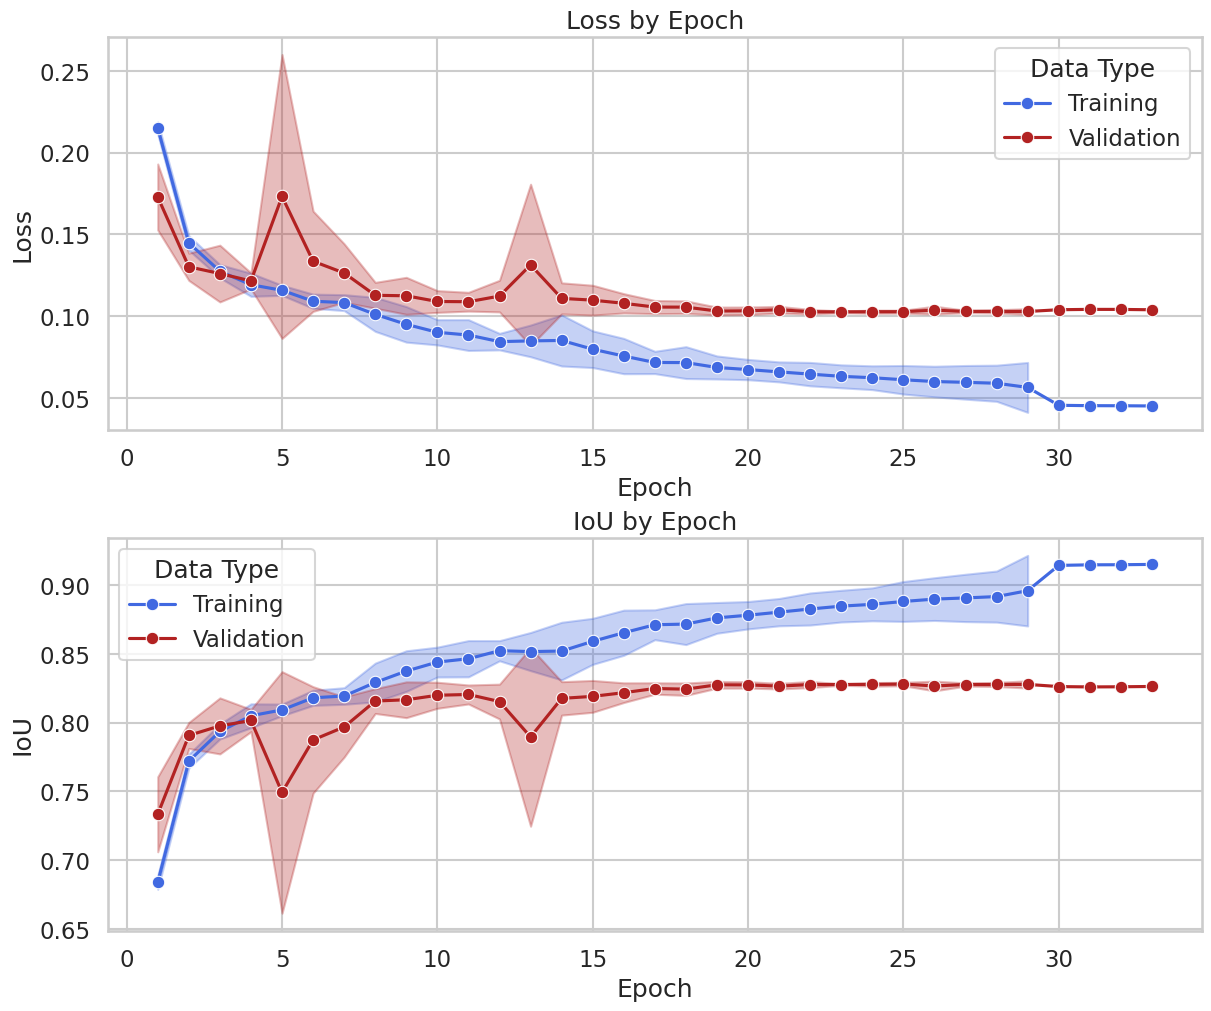

In [2]:
# Initialize the plotter with the DataFrame
plotter = SimpleTrainingMetricsPlotter(pd.read_csv(TRAINING_DATA_PATH))

# Plot the metrics
plotter.plot_metrics()

In [8]:
df = pd.read_csv('/app/training_data/deep_lab/training.csv')

best_fold_row = df.loc[df['val_loss'].idxmin()]
print(best_fold_row)

train_loss    0.077900
train_iou     0.862039
val_loss      0.100045
val_iou       0.830638
fold          5.000000
Name: 124, dtype: float64


In [9]:
df = pd.read_csv('/app/training_data/unet/training.csv')

best_fold_row = df.loc[df['val_loss'].idxmin()]
print(best_fold_row)

train_loss    0.058244
train_iou     0.893287
val_loss      0.098719
val_iou       0.832486
fold          2.000000
Name: 51, dtype: float64


In [10]:
df = pd.read_csv('/app/training_data/unet_plus_plus/training.csv')

best_fold_row = df.loc[df['val_loss'].idxmin()]
print(best_fold_row)

train_loss    0.060436
train_iou     0.890275
val_loss      0.095111
val_iou       0.838604
fold          3.000000
Name: 62, dtype: float64


In [3]:
INPUT_SIZE = (256, 256)
BATCH_SIZE = 16
mean = [0.485, 0.456, 0.406]  # Mean for each channel (R, G, B)
std = [0.229, 0.224, 0.225]   # Standard deviation for each channel (R, G, B)

# Transforms
transform = transforms.Compose([
    transforms.Resize(INPUT_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Test dataset
test_dataset = SkinLesionDataset(TEST_IMAGES_PATH, TEST_MASKS_PATH, transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=20, pin_memory=True)


In [4]:
# Initialize your dataset and DataLoader
test_dataset = SkinLesionDataset(TEST_IMAGES_PATH, TEST_MASKS_PATH, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

metrics_list = []
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for _, best_model_path in enumerate(BEST_MODELS_PATHS):
        
    # Load your model and device
    #model = get_pretrained_unet()
    load_model_weights(model, best_model_path)

    # Initialize the tester and run the test
    tester = SegmentationModelTester(model, device, test_loader)
    metrics = tester.test()

    # Append value from current fold
    metrics_list.append(metrics)

    # Print out the results
    print(metrics)

Generating Masks: 100%|██████████| 63/63 [01:47<00:00,  1.71s/it]


{'mean_iou': 0.7937063887890373, 'mean_dice': 0.8741337224926472, 'mean_precision': 0.8526266357086983, 'mean_recall': 0.9343139597207906, 'mean_f1': 0.8741338029723952}


Generating Masks: 100%|██████████| 63/63 [01:44<00:00,  1.66s/it]


{'mean_iou': 0.8019455830338841, 'mean_dice': 0.8810962392467249, 'mean_precision': 0.8592172948444766, 'mean_recall': 0.9368840624133472, 'mean_f1': 0.8810963133134782}


Generating Masks: 100%|██████████| 63/63 [01:45<00:00,  1.67s/it]


{'mean_iou': 0.7986451815405677, 'mean_dice': 0.8772337071770189, 'mean_precision': 0.8645986594781916, 'mean_recall': 0.9272648306178043, 'mean_f1': 0.87723378507629}


Generating Masks: 100%|██████████| 63/63 [01:44<00:00,  1.66s/it]


{'mean_iou': 0.79573861008661, 'mean_dice': 0.8745155308333141, 'mean_precision': 0.8649593360998455, 'mean_recall': 0.9228225474049475, 'mean_f1': 0.8745156121098789}


Generating Masks: 100%|██████████| 63/63 [01:44<00:00,  1.66s/it]

{'mean_iou': 0.7973270794888552, 'mean_dice': 0.876503491502355, 'mean_precision': 0.8621768159679959, 'mean_recall': 0.9284157794008254, 'mean_f1': 0.8765035701110087}


In [19]:
# # Initialize a dictionary to store the sums
# sum_metrics = {key: 0 for key in metrics_list[0].keys()}

# # Sum the values for each metric across all dictionaries
# for metrics in metrics_list:
#     for key in metrics:
#         sum_metrics[key] += metrics[key]

# # Calculate the mean for each metric
# mean_metrics = {key: sum_metrics[key] / len(metrics_list) for key in sum_metrics}

# print("Mean metrics:", mean_metrics)

Mean metrics: {'mean_iou': 0.7974725685877908, 'mean_dice': 0.8766965382504119, 'mean_precision': 0.8607157484198416, 'mean_recall': 0.929940235911543, 'mean_f1': 0.8766966167166104}


In [22]:
import os
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm
from scipy.ndimage import binary_fill_holes, label
from models import get_pretrained_unet_plus_plus, load_model_weights


# Transforms
INPUT_SIZE = (256, 256)
BATCH_SIZE = 16
mean = [0.485, 0.456, 0.406]  # Mean for each channel (R, G, B)
std = [0.229, 0.224, 0.225]   # Standard deviation for each channel (R, G, B)

# Transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(INPUT_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Load the new dataset
new_dataset = SkinLesionMaskGeneratorDataset('/app/data/ISIC2018_Task3_Test_Images_No_Hair', transform)
new_loader = DataLoader(new_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Load the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = get_pretrained_unet_plus_plus()
load_model_weights(model, BEST_MODELS_PATHS[2])  # Load the weights from one of the best models
model.to(device)
model.eval()  # Set the model to evaluation mode

def post_process_mask(mask):
    """
    Apply morphological operations to clean up the mask, fill holes, and remove floating islands.
    """
    # Ensure mask is binary
    mask = mask.astype(np.uint8)

    # Apply a morphological closing operation (dilate followed by erosion)
    kernel = np.ones((7, 7), np.uint8)  # Increased kernel size for more aggressive closing
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    # Fill small holes inside the mask
    mask = binary_fill_holes(mask).astype(np.uint8)

    # Label connected components
    labeled_mask, num_features = label(mask)
    
    # Keep only the largest connected component
    if num_features > 1:
        sizes = np.bincount(labeled_mask.ravel())
        largest_component = sizes[1:].argmax() + 1
        mask = (labeled_mask == largest_component).astype(np.uint8)
    
    return mask

# Generate masks
with torch.no_grad():
    for i, (images, img_names) in enumerate(tqdm(new_loader)):
        images = images.to(device)
        outputs = model(images)
        predicted_masks = torch.sigmoid(outputs)  # Assuming binary segmentation, use sigmoid to get probabilities
        predicted_masks = (predicted_masks > 0.5).float()  # Convert probabilities to binary masks

        # Save the generated masks
        for j in range(predicted_masks.size(0)):
            mask = predicted_masks[j].cpu().numpy().squeeze()  # Convert to NumPy array and remove single channel

            # Post-process the mask
            mask = post_process_mask(mask)

            # Correct the filename by removing the extension and adding '_segmentation.png'
            base_name = os.path.splitext(img_names[j])[0]  # Remove the original extension (.jpg, .png)
            output_path = os.path.join('/app/data/ISIC2018_Task3_Test_GroundTruth', f'{base_name}_segmentation.png')
            
            # Save the processed mask
            plt.imsave(output_path, mask, cmap='gray')

print("Mask generation and post-processing completed.")


100%|██████████| 95/95 [00:30<00:00,  3.14it/s]

Mask generation and post-processing completed.
